## Import packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
%matplotlib inline

In [2]:
data_ori = pd.read_csv("appdata10.csv")
data = data_ori.copy()

## Data inspection

In [3]:
data.head(3)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1


In [4]:
data.info()
# all date format need to be converted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user                  50000 non-null  int64 
 1   first_open            50000 non-null  object
 2   dayofweek             50000 non-null  int64 
 3   hour                  50000 non-null  object
 4   age                   50000 non-null  int64 
 5   screen_list           50000 non-null  object
 6   numscreens            50000 non-null  int64 
 7   minigame              50000 non-null  int64 
 8   used_premium_feature  50000 non-null  int64 
 9   enrolled              50000 non-null  int64 
 10  enrolled_date         31074 non-null  object
 11  liked                 50000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


In [5]:
data.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


## Data cleaning and EDA

In [6]:
# converting timestamp to int 
data['hour'] = data.hour.str.slice(stop=3).astype(int)

In [7]:
data.columns

Index(['user', 'first_open', 'dayofweek', 'hour', 'age', 'screen_list',
       'numscreens', 'minigame', 'used_premium_feature', 'enrolled',
       'enrolled_date', 'liked'],
      dtype='object')

In [8]:
for_histogram = data.drop(columns=['user','screen_list','enrolled_date','first_open','enrolled'])

C:\Users\Admin\anaconda3\envs\testingenv\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


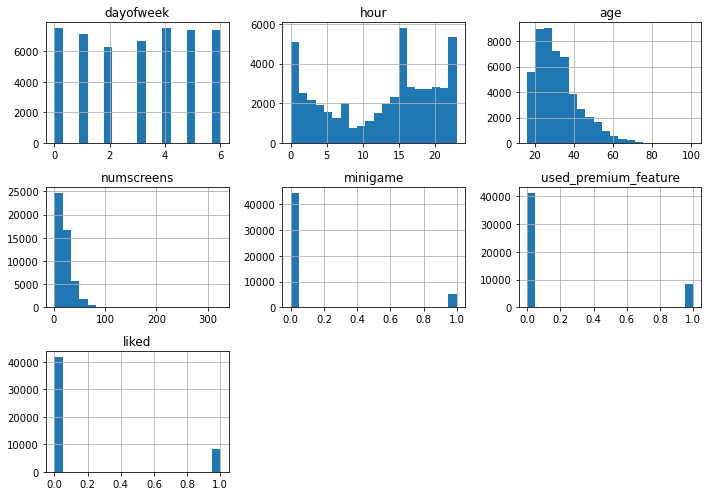

In [9]:
for_histogram.hist(figsize=(10,7), bins=20);
plt.tight_layout()

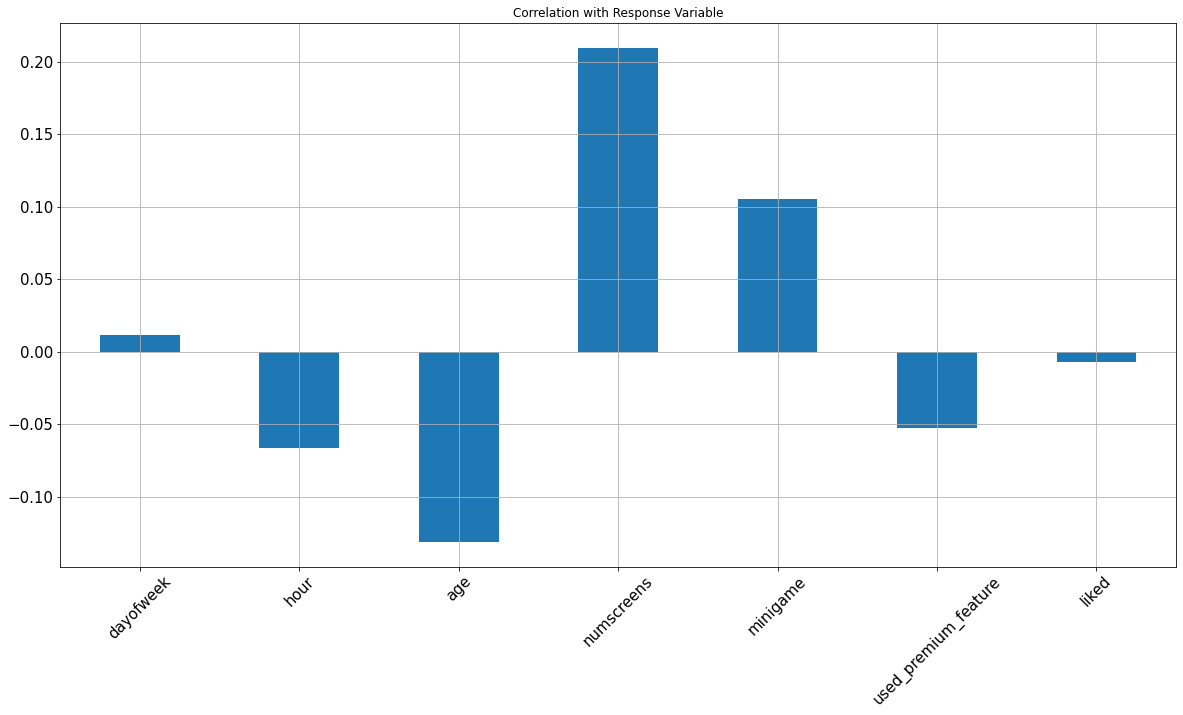

In [10]:
# correlation with response
for_histogram.corrwith(data.enrolled).plot.bar(figsize=(20,10),
                       title='Correlation with Response Variable',
                       fontsize=15, rot=45, grid=True);

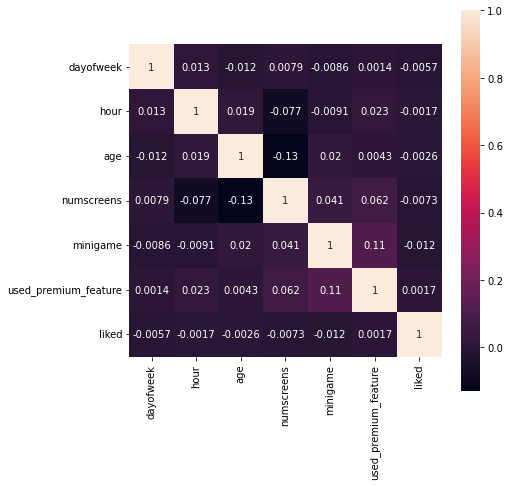

In [11]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(7,7))
cor = for_histogram.corr()
sns.heatmap(cor, annot=True, square=True);

## Feature engineering - Response

In [12]:
# date range limit 
# looking the datatype
data.dtypes 

user                     int64
first_open              object
dayofweek                int64
hour                     int32
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [13]:
data["first_open"] = [parser.parse(row_data) for row_data in data["first_open"]]
data["enrolled_date"] = [parser.parse(row_data) if isinstance(row_data,str) else row_data for row_data in data["enrolled_date"]]

In [14]:
data["difference"] = (data.enrolled_date - data.first_open).astype('timedelta64[h]')

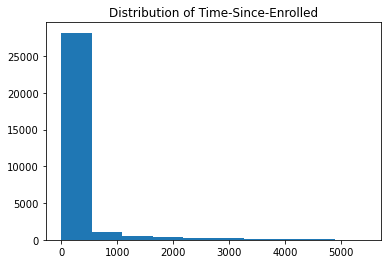

In [15]:
plt.hist(data.difference.dropna());
plt.title('Distribution of Time-Since-Enrolled')
plt.show();
# we can see that majority of peeople enrolled in first 500 hrs
# lets drill down a bit more further

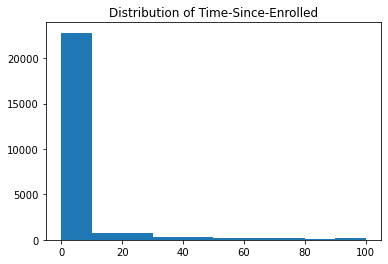

In [16]:
plt.hist(data.difference.dropna(), range=(0,100));
plt.title('Distribution of Time-Since-Enrolled')
plt.show();
# now we see that its is only within the first 100 hrs

In [17]:
# putting the time limit within 2 days = 48 hrs
# below codes will set the enrollement to 0/not enrolled if its more than 48 hrs
data.loc[data.difference > 48, 'enrolled'] = 0

In [18]:
# dropping the less necessaries columns such 'difference', 'first_open' and 'enrolled_date'
data = data.drop(columns=['difference', 'first_open', 'enrolled_date'])

## Feature engineering - Screens

In [19]:
# importing list of popular screen
top_screen = pd.read_csv('top_screens.csv').top_screens.values

In [20]:
type(top_screen)

numpy.ndarray

In [21]:
data['screen_list'] = data.screen_list.astype(str) + ','

In [22]:
for sc in top_screen:
    data[sc] = data.screen_list.str.contains(sc).astype(int)
    data["screen_list"] = data.screen_list.str.replace(sc+ ",", "")

In [23]:
# assign 'other' column for least popular screen, leftover screen
data['other'] = data.screen_list.str.count(",")

In [24]:
data = data.drop(columns=['screen_list'])

In [25]:
# funnels
savings_screens = ["Saving1","Saving2","Saving2Amount","Saving4","Saving5","Saving6","Saving7","Saving8","Saving9",
                   "Saving10"]

data["savingsCount"] = data[savings_screens].sum(axis=1)
data = data.drop(columns=savings_screens)

In [26]:
cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
data["CMCount"] = data[cm_screens].sum(axis=1)
dataset = data.drop(columns=cm_screens)

In [27]:
cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
data["CCCount"] = data[cc_screens].sum(axis=1)
dataset = data.drop(columns=cc_screens)

In [28]:
loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
data["LoansCount"] = data[loan_screens].sum(axis=1)
dataset = data.drop(columns=loan_screens)

In [29]:
# saving the new data
data.to_csv('new_data.csv', index=False)